<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/defaults/data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Ingestion

In [1]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
# ddfimport.ddf_source_control_pane()
ddfimport.ddf_import_common()

import dataset
import raster

executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


## Load dataset

Please select the source of your data to process. Only SAMPLE_CSV_PATH will be used if SAMPLE_SOURCE is set to "GOOGLE DRIVE":

In [2]:
import ipywidgets as widgets

#@markdown ## Data Source

SAMPLE_SOURCE = "TIMBERID" #@param ["TIMBERID", "GOOGLE DRIVE"]

#@markdown For TIMERBID SAMPLE_SOURCE only
ORG_NAME = "google" #@param ["google", "USP"]
TEST_ENVIRONMENT = True #@param {type:"boolean"}
#@markdown For GOOGLE DRIVE SAMPLE_SOURCE only
SAMPLE_CSV_PATH = "canonical/2023_07_27_Results_google_relabeled.csv" #@param

if SAMPLE_SOURCE == "TIMBERID":
  df = dataset.load_reference_samples(org_name=ORG_NAME,
                                      filters=[],
                                      test_environment=TEST_ENVIRONMENT)
elif SAMPLE_SOURCE == "GOOGLE DRIVE":
  raster.mount_gdrive()
  df = pd.read_csv(raster.get_sample_db_path(SAMPLE_CSV_PATH), encoding="ISO-8859-1", sep=',')

#@markdown For both sample sources
MANUAL_OVERRIDE_COLUMNS = False #@param {type: "boolean"}

# Internal. The values to select by default
default_values = {
    'Code': True,
    'lat': True,
    'long': True,
    'VPD': True,
    'RH': True,
    'DEM': True,
    'PA': True,
    'PET': True,
    'Mean Annual Temperature': True,
    'Mean Annual Precipitation': True,
    'Iso_Oxi_Stack_mean_TERZER': True,
    'predkrig_br_lat_ISORG': True,
    'brisoscape_mean_ISORIX': True,
    'isoscape_fullmodel_d18O_prec_REGRESSION': True
}
data = df.columns
feature_checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
for i in range(0, len(feature_checkboxes)):
    if feature_checkboxes[i].description in default_values:
      feature_checkboxes[i].value = True
if MANUAL_OVERRIDE_COLUMNS:
  output = widgets.VBox(children=feature_checkboxes)
  print("Select the features for your model:")
  display(output)


data = df.columns
default_values = {
    'd18O_cel': True
}
label_checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
for i in range(0, len(label_checkboxes)):
    if label_checkboxes[i].description in default_values:
      label_checkboxes[i].value = True
if MANUAL_OVERRIDE_COLUMNS:
  output = widgets.VBox(children=label_checkboxes)
  print("Select the labels of your model:")
  display(output)

#@markdown ## Partition Data
#
#@markdown Based on the columns available, you'll select the keys by which we'll split your data into training, validation and test splits. This will make sure that there's a single group of measurements in either of the splits, and not an incomplete unit across many partitions.
#
#@markdown PARTITION_STRATEGY: The columns that will be used to group the dataset to calculate means and variance on LABEL_COLUMNS. Values can be
#@markdown - FIXED
#@markdown - RANDOM

PARTITION_STRATEGY = "FIXED" #@param ["FIXED", "RANDOM"]
GROUPING_COLUMNS = ["Code", "lat", "long"] #@param

#@markdown KEEP_GROUPING: If True, the exported rows will have unique values of the grouping columns selected above. If False, the exported rows will still contain the mean, variance, and other statistics for each group, but the original set of rows will be exported without combining any rows.

KEEP_GROUPING = True #@param {type: "boolean"}

Select the features for your model:


Select the labels of your model:


In [3]:
# @title
selected_data = []
for i in range(0, len(feature_checkboxes)):
    if feature_checkboxes[i].value == True:
        selected_data = selected_data + [feature_checkboxes[i].description]
print("Selected features: ", selected_data)
FEATURE_COLUMNS = selected_data

selected_data = []
for i in range(0, len(label_checkboxes)):
    if label_checkboxes[i].value == True:
        assert(label_checkboxes[i].description not in FEATURE_COLUMNS)
        selected_data = selected_data + [label_checkboxes[i].description]
print("Selected labels: ", selected_data)
LABEL_COLUMNS = selected_data

print("Partitioning strategy: ", PARTITION_STRATEGY)
print("Grouping columns:", GROUPING_COLUMNS)

Selected features:  ['Code', 'lat', 'long', 'VPD', 'RH', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'predkrig_br_lat_ISORG', 'brisoscape_mean_ISORIX', 'isoscape_fullmodel_d18O_prec_REGRESSION']
Selected labels:  ['d18O_cel']
Partitioning strategy:  FIXED
Grouping columns: ['Code', 'lat', 'long']


## Pre-Process and Split Data

In [4]:
# @title Run this cell to pre-process and split data
import partitioned_dataset
import dataset

import importlib
importlib.reload(dataset)
importlib.reload(partitioned_dataset)
import dataset
import partitioned_dataset

from partitioned_dataset import PartitionStrategy

for column in LABEL_COLUMNS:
  df[column] = df[column].astype(float)

sample_data = dataset.preprocess_sample_data(df, FEATURE_COLUMNS, LABEL_COLUMNS, GROUPING_COLUMNS, KEEP_GROUPING)

resulting_dataset = None
if PARTITION_STRATEGY == "FIXED":
  resulting_dataset = partitioned_dataset.partition(sample_data, PartitionStrategy.FIXED)
elif PARTITION_STRATEGY == "RANDOM":
  resulting_dataset = partitioned_dataset.partition(sample_data, PartitionStrategy.RANDOM)
else:
  raise ValueError(f"Unknown partition strategy: {PARTITION_STRATEGY}")

train_data = resulting_dataset.train
validation_data = resulting_dataset.validation
test_data = resulting_dataset.test


## (Optional) Visualize data

Rows in training set: 73
Rows in validation set:  40
Rows in test set: 106


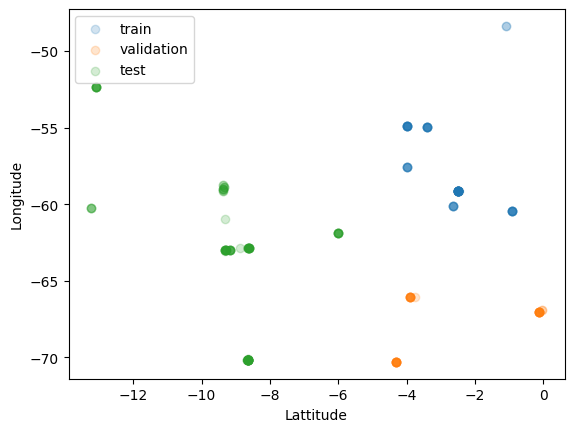

In [5]:
# @title Run this cell to visualize your partitioned data.
print("Rows in training set:", train_data.shape[0])
print("Rows in validation set: ", validation_data.shape[0])
print("Rows in test set:", test_data.shape[0])

# Optional (plot splits)
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(train_data["lat"], train_data["long"], label="train", alpha=0.2)
plt.scatter(validation_data["lat"], validation_data["long"], label="validation", alpha=0.2)
plt.scatter(test_data["lat"], test_data["long"], label="test", alpha=0.2)
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

## Export processed dataset

In [6]:
OUTPUT_DATASET_NAME="demo" #@param
OUTPUT_DATASET_ROOT = "" #@param
GROUPING_STR = "grouped" if KEEP_GROUPING else "ungrouped"

OUTPUT_TRAIN_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_train_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_VALIDATION_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_validation_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_TEST_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_test_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"

print("OUTPUT_TRAIN_CSV_PATH: ", raster.get_sample_db_path(
    OUTPUT_TRAIN_CSV_PATH))
print("OUTPUT_VALIDATION_CSV_PATH: ", raster.get_sample_db_path(
    OUTPUT_VALIDATION_CSV_PATH))
print("OUTPUT_TEST_CSV_PATH: ", raster.get_sample_db_path(
    OUTPUT_TEST_CSV_PATH))

train_data.to_csv(raster.get_sample_db_path(OUTPUT_TRAIN_CSV_PATH))
validation_data.to_csv(raster.get_sample_db_path(OUTPUT_VALIDATION_CSV_PATH))
test_data.to_csv(raster.get_sample_db_path(OUTPUT_TEST_CSV_PATH))

OUTPUT_TRAIN_CSV_PATH:  /content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/demo_train_fixed_grouped.csv
OUTPUT_VALIDATION_CSV_PATH:  /content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/demo_validation_fixed_grouped.csv
OUTPUT_TEST_CSV_PATH:  /content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/demo_test_fixed_grouped.csv
